# Estimación de peso y dimensiones de los envíos de Mercado Libre

Este notebook es una versión mínima y necesaria para poder levantar el dataset [meli_dataset_20190426.csv](https://drive.google.com/open?id=1tNUKD1lf1z8C7LPpCruiDl6SKBAHb79v) y comprender los features que éste contiene.

## Sobre el dataset
El dataset corresponde a un muestreo de envíos durante tres meses de 2018 en MLB (Mercado Libre Brasil), filtrados según métodos de envíos y por carriers (empresas de correos a cargo del envío propiamente dicho). A su vez, fue muestreado de forma no uniforme para romper de forma manual la distribución de los datos.

#### ¿Qué significa cada columna?

* ITEM_ID: id unívoco de cada item publicado. (Ofuscado)
* SHP_WEIGHT: peso del paquete informado por el correo.
* SHP_LENGTH: largo del paquete informado por el correo.
* SHP_WIDTH: ancho del paquete informado por el correo.
* SHP_HEIGHT: altura del paquete informado por el correo.
* ATTRIBUTES: atributos como marca y modelo, entre otros, en formato json-lines
* CATALOG_PRODUCT_ID: id del catálogo (ofuscado).
* CONDITION: condición de venta (nuevo o usado).
* DOMAIN_ID: id de la categoría a la que pertenece la publicación.
* PRICE: precio en reales.
* SELLER_ID: id del vendedor (ofuscado).
* STATUS: estado de la publicación (activa, cerrada, pausada, etc.)
* TITLE: título de la publicación.

El objetivo del análisis es predecir el peso y tamaño de los artículos. A su vez el tamaño se puede descomponer en largo, altura y ancho.  Las cuatro variables a predecir son numéricas continuas .
Probablemente la variable explicativa más importante sea CATALOG_PRODUCT_ID, dado que si se conoce el peso y tamaño de un artículo, los próximos envíos deberían tener las mismas características. 

En el caso de envíos de productos no catalogados previamente, es de esperar que tomen relevancia las variables ATRIBUTES, TITTLE, SELLER_ID, DOMANIN_ID. En el caso de atributes, hay que preprocesar los datoa pra poder extraer algo de información.

Luego se dispone de otras variables complementarias, cuya incorporación podría incrementar el poder predictivo del modelo: CONDITION, STATUS, PRICE.

En primer lugar es conveniente relizar un análisis descriptivo, principalmente de las variables que se desea predecir.

## Carga de la base de datos

In [10]:
#importación de bibliotecas
library(readr)
library(psych)
library(ggplot2)
options(repr.plot.width=5, repr.plot.height=3)
#carga del dataset
df  <- read_csv("~/GitHub/mentoria_pesos_medidas_diplo2019/meli_dataset_20190426.csv")

Parsed with column specification:
cols(
  ITEM_ID = col_character(),
  SHP_WEIGHT = col_double(),
  SHP_LENGTH = col_double(),
  SHP_WIDTH = col_double(),
  SHP_HEIGHT = col_double(),
  ATTRIBUTES = col_character(),
  CATALOG_PRODUCT_ID = col_character(),
  CONDITION = col_character(),
  DOMAIN_ID = col_character(),
  PRICE = col_double(),
  SELLER_ID = col_character(),
  STATUS = col_character(),
  TITLE = col_character()
)


## Descripción express del dataset

In [2]:
names(df)

[1] "ITEM_ID"            "SHP_WEIGHT"         "SHP_LENGTH"        
 [4] "SHP_WIDTH"          "SHP_HEIGHT"         "ATTRIBUTES"        
 [7] "CATALOG_PRODUCT_ID" "CONDITION"          "DOMAIN_ID"         
[10] "PRICE"              "SELLER_ID"          "STATUS"            
[13] "TITLE"

In [3]:
summary(df)

   ITEM_ID            SHP_WEIGHT       SHP_LENGTH       SHP_WIDTH     
 Length:499948      Min.   :    1    Min.   :  0.00   Min.   :  0.00  
 Class :character   1st Qu.:  260    1st Qu.: 20.00   1st Qu.: 13.00  
 Mode  :character   Median :  675    Median : 25.00   Median : 20.00  
                    Mean   : 1855    Mean   : 31.45   Mean   : 21.29  
                    3rd Qu.: 1900    3rd Qu.: 36.00   3rd Qu.: 25.00  
                    Max.   :50000    Max.   :288.20   Max.   :165.00  
                    NA's   :152197   NA's   :152197   NA's   :152197  
   SHP_HEIGHT      ATTRIBUTES        CATALOG_PRODUCT_ID  CONDITION        
 Min.   :  0.00   Length:499948      Length:499948      Length:499948     
 1st Qu.:  5.00   Class :character   Class :character   Class :character  
 Median : 10.00   Mode  :character   Mode  :character   Mode  :character  
 Mean   : 11.58                                                           
 3rd Qu.: 16.00                                          

In [11]:
# Eliminación de faltantes de las variables a predecir
df <- df[ !is.na(df$SHP_WEIGHT) &!is.na(df$SHP_LENGTH)
          & !is.na(df$SHP_WIDTH) & !is.na(df$SHP_HEIGHT),]

#head(df[2:5])

### Estadisticas descriptivas de las variables a predecir

In [6]:
describeBy(df[2:5], IQR=TRUE)

Warning message in describeBy(df[2:5], IQR = TRUE):
"no grouping variable requested"

,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
SHP_WEIGHT,1,347751,1854.78958,3257.884009,675,1089.61017,763.5390,1,50000.0,49999.0,3.915336,20.399119,5.52460744
SHP_LENGTH,2,347751,31.45115,18.339895,25,28.45987,10.3782,0,288.2,288.2,2.210774,7.986324,0.03110016
SHP_WIDTH,3,347751,21.29028,11.217308,20,19.84083,8.8956,0,165.0,165.0,1.448877,4.010070,0.01902192
SHP_HEIGHT,4,347751,11.57858,8.310821,10,10.45260,7.4130,0,105.0,105.0,1.423123,2.942553,0.01409320


### Estadisticas descriptivas de las variables a predecir discriminando por condition y status

In [7]:
describeBy(df[2:5],df$CONDITION ,IQR=TRUE)
describeBy(df[2:5],df$STATUS ,IQR=TRUE)


 Descriptive statistics by group 
group: new
           vars      n    mean      sd median trimmed    mad min     max
SHP_WEIGHT    1 260579 1922.40 3304.07    714 1154.80 822.84   1 50000.0
SHP_LENGTH    2 260579   31.92   19.05     25   28.74  10.38   0   288.2
SHP_WIDTH     3 260579   21.61   11.48     20   20.13   8.90   0   165.0
SHP_HEIGHT    4 260579   11.77    8.46     10   10.64   7.41   0   105.0
             range skew kurtosis   se    IQR
SHP_WEIGHT 49999.0 3.88    20.36 6.47 1790.0
SHP_LENGTH   288.2 2.22     7.86 0.04   17.0
SHP_WIDTH    165.0 1.44     3.96 0.02   12.6
SHP_HEIGHT   105.0 1.39     2.81 0.02   11.0
------------------------------------------------------------ 
group: not_specified
           vars   n    mean      sd median trimmed    mad min   max range skew
SHP_WEIGHT    1 356 1268.47 2717.33    400  644.36 424.76  10 21000 20990 4.56
SHP_LENGTH    2 356   27.78   13.97     25   26.35   7.41   0   103   103 1.60
SHP_WIDTH     3 356   19.26    9.28     19  


 Descriptive statistics by group 
group: 404
           vars     n    mean      sd median trimmed    mad min   max range
SHP_WEIGHT    1 51426 1818.35 3276.26 661.00 1023.26 682.00   1 50000 49999
SHP_LENGTH    2 51426   31.60   16.64  25.35   29.39   8.38   0   245   245
SHP_WIDTH     3 51426   21.13   10.72  20.00   19.81   7.41   0   100   100
SHP_HEIGHT    4 51426   11.67    8.03  10.00   10.61   7.41   0    80    80
           skew kurtosis    se     IQR
SHP_WEIGHT 3.78    17.57 14.45 1366.75
SHP_LENGTH 1.92     6.75  0.07   17.00
SHP_WIDTH  1.36     3.50  0.05   11.00
SHP_HEIGHT 1.44     3.08  0.04   10.00
------------------------------------------------------------ 
group: active
           vars      n    mean      sd median trimmed    mad min   max range
SHP_WEIGHT    1 161502 1890.00 3149.06    750 1173.29 870.29   1 50000 49999
SHP_LENGTH    2 161502   31.78   18.72     25   28.76  10.38   0   275   275
SHP_WIDTH     3 161502   21.68   11.29     20   20.31   8.90   0   115  

### Analisis univariado de SHP_WEIGHT

Warning message in describeBy(df$SHP_WEIGHT, IQR = TRUE):
"no grouping variable requested"

,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
X1,1,347751,1854.79,3257.884,675,1089.61,763.539,1,50000,49999,3.915336,20.39912,5.524607


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


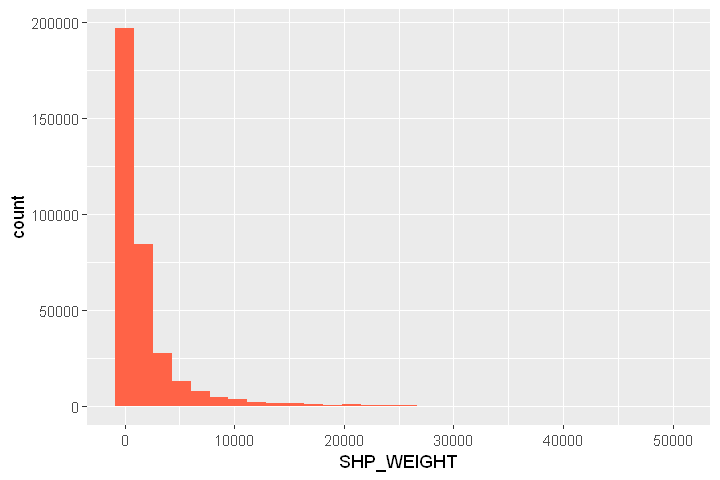

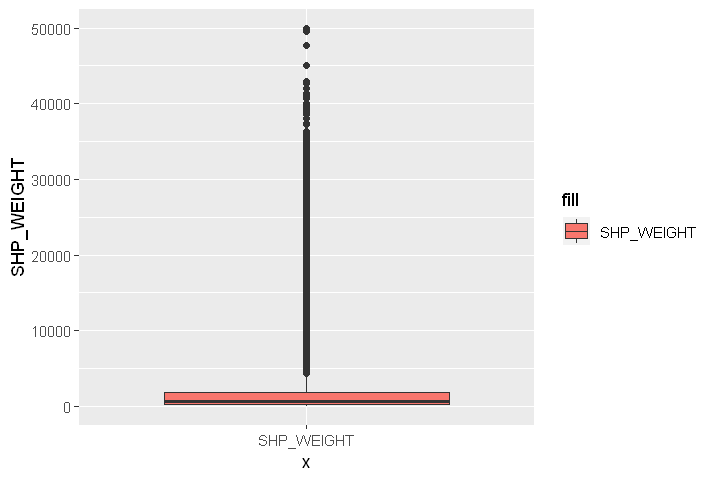

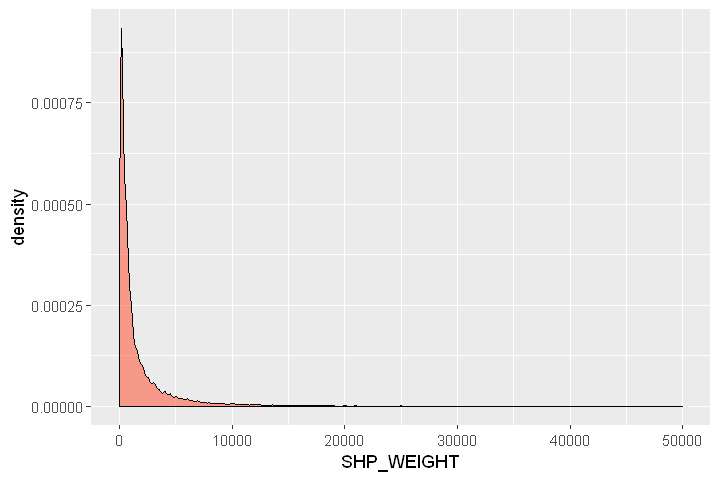

In [12]:
describeBy(df$SHP_WEIGHT , IQR=TRUE)

ggplot(df, aes(SHP_WEIGHT))+
  geom_histogram(fill = "tomato")

ggplot(df, aes(x="SHP_WEIGHT", SHP_WEIGHT))+
  geom_boxplot(aes(fill = "SHP_WEIGHT"))

ggplot(df, aes(SHP_WEIGHT)) + 
geom_density( fill = "tomato", alpha=0.6)


### Analisis univariado de SHP_WEIGHT discriminando por CONDITION



 Descriptive statistics by group 
group: new
   vars      n   mean      sd median trimmed    mad min   max range skew
X1    1 260579 1922.4 3304.07    714  1154.8 822.84   1 50000 49999 3.88
   kurtosis   se  IQR
X1    20.36 6.47 1790
------------------------------------------------------------ 
group: not_specified
   vars   n    mean      sd median trimmed    mad min   max range skew kurtosis
X1    1 356 1268.47 2717.33    400  644.36 424.76  10 21000 20990 4.56    23.72
       se   IQR
X1 144.02 888.5
------------------------------------------------------------ 
group: used
   vars    n    mean      sd median trimmed    mad min   max range skew
X1    1 1023 2074.97 3743.08    580 1165.24 653.83  10 30000 29990 3.42
   kurtosis     se  IQR
X1    14.26 117.03 1780

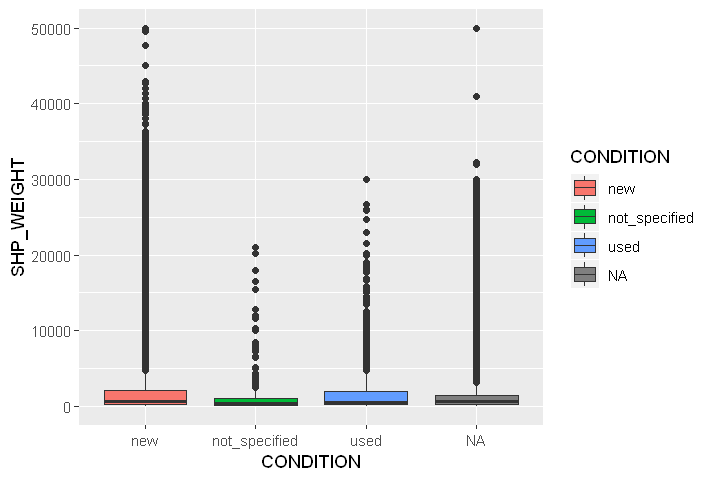

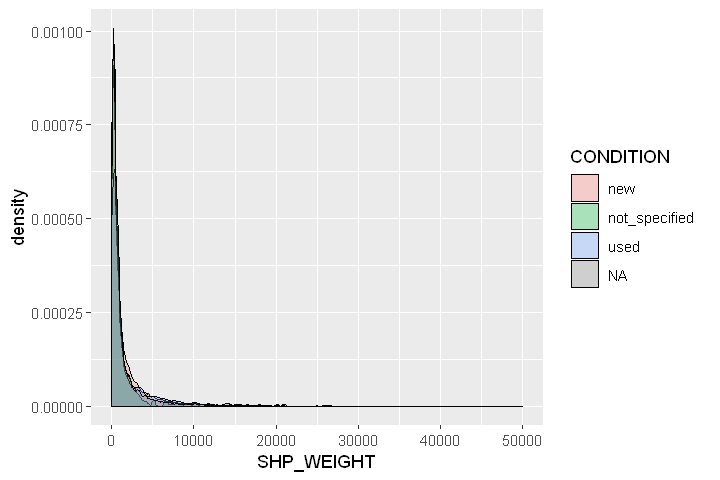

In [14]:
describeBy(df$SHP_WEIGHT ,df$CONDITION ,IQR=TRUE)

ggplot(df, aes(CONDITION, SHP_WEIGHT))+
  geom_boxplot(aes(fill=CONDITION))

ggplot(df, aes(SHP_WEIGHT )) + 
geom_density( aes(fill = CONDITION), alpha=0.3)


### Analisis univariado de SHP_WEIGHT discriminando por STATUS


 Descriptive statistics by group 
group: 404
   vars     n    mean      sd median trimmed mad min   max range skew kurtosis
X1    1 51426 1818.35 3276.26    661 1023.26 682   1 50000 49999 3.78    17.57
      se     IQR
X1 14.45 1366.75
------------------------------------------------------------ 
group: active
   vars      n mean      sd median trimmed    mad min   max range skew kurtosis
X1    1 161502 1890 3149.06    750 1173.29 870.29   1 50000 49999 3.94    21.77
     se  IQR
X1 7.84 1800
------------------------------------------------------------ 
group: closed
   vars     n    mean      sd median trimmed    mad min   max range skew
X1    1 18442 2208.93 3877.65    702 1267.73 827.29   1 42900 42899 3.43
   kurtosis    se     IQR
X1    14.63 28.55 1982.25
------------------------------------------------------------ 
group: inactive
   vars    n    mean      sd median trimmed    mad min   max range skew
X1    1 3026 1329.11 2422.12    600  766.62 628.62  10 21100 21090 4.32
   k

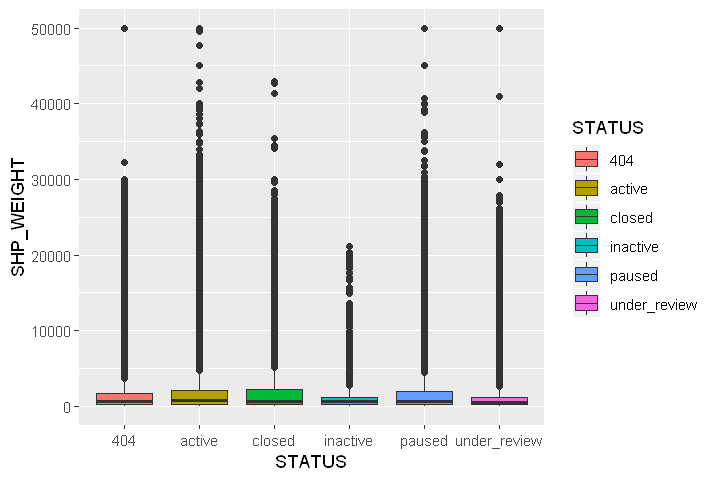

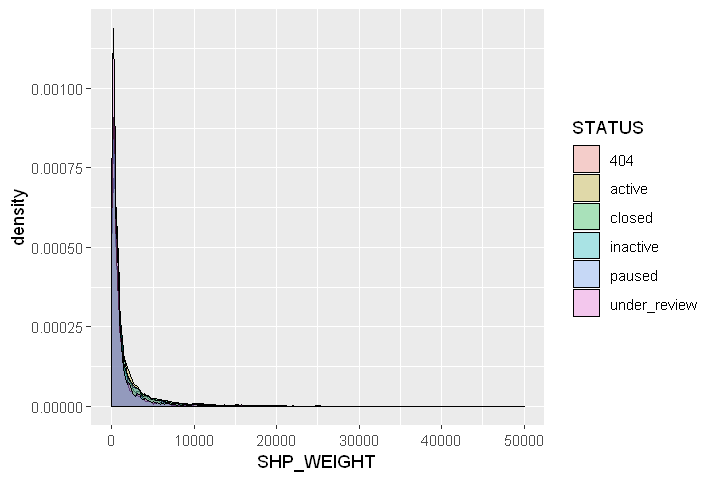

In [15]:
describeBy(df$SHP_WEIGHT ,df$STATUS ,IQR=TRUE)

ggplot(df, aes(STATUS, SHP_WEIGHT))+
  geom_boxplot(aes(fill=STATUS))

ggplot(df, aes(SHP_WEIGHT )) + 
  geom_density( aes(fill = STATUS), alpha=0.3)

### Analisis univariado de SHP_LENGTH

Warning message in describeBy(df$SHP_LENGTH, IQR = TRUE):
"no grouping variable requested"

,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
X1,1,347751,31.45115,18.33989,25,28.45987,10.3782,0,288.2,288.2,2.210774,7.986324,0.03110016


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


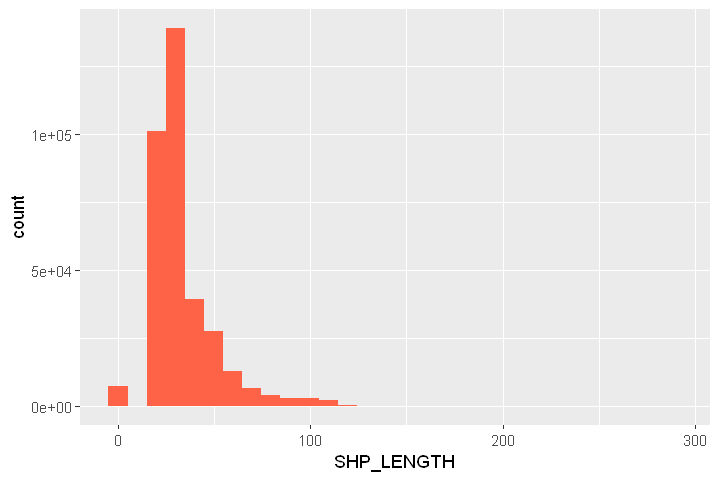

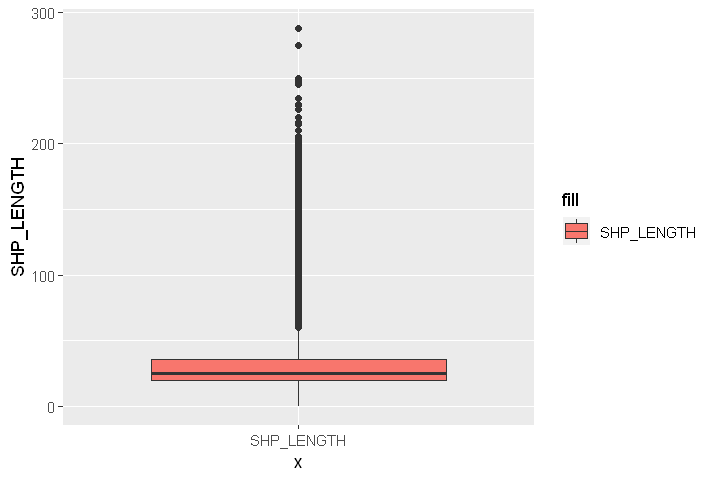

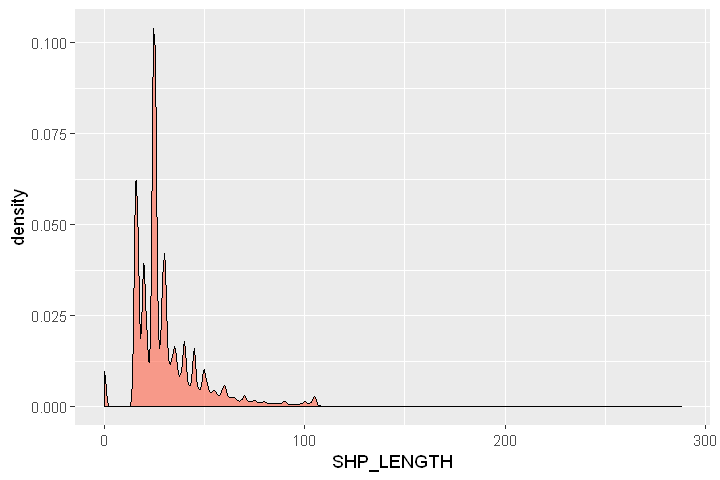

In [16]:
describeBy(df$SHP_LENGTH , IQR=TRUE)

ggplot(df, aes(SHP_LENGTH))+
  geom_histogram(fill = "tomato")

ggplot(df, aes(x="SHP_LENGTH", SHP_LENGTH))+
  geom_boxplot(aes(fill = "SHP_LENGTH"))

ggplot(df, aes(SHP_LENGTH)) + 
  geom_density( fill = "tomato", alpha=0.6)

### Analisis univariado de SHP_LENGTH discriminando por CONDITION


 Descriptive statistics by group 
group: new
   vars      n  mean    sd median trimmed   mad min   max range skew kurtosis
X1    1 260579 31.92 19.05     25   28.74 10.38   0 288.2 288.2 2.22     7.86
     se IQR
X1 0.04  17
------------------------------------------------------------ 
group: not_specified
   vars   n  mean    sd median trimmed  mad min max range skew kurtosis   se
X1    1 356 27.78 13.97     25   26.35 7.41   0 103   103  1.6     5.81 0.74
   IQR
X1  11
------------------------------------------------------------ 
group: used
   vars    n  mean    sd median trimmed  mad min max range skew kurtosis   se
X1    1 1023 29.89 15.77     25   27.59 7.41   0 105   105 1.95     5.63 0.49
   IQR
X1  15

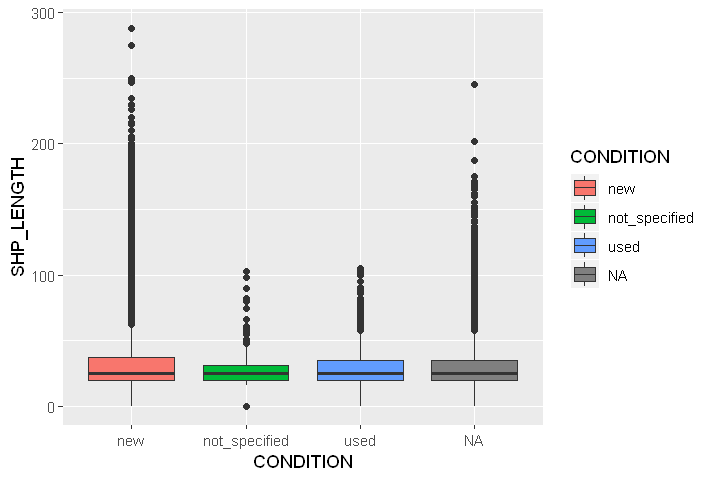

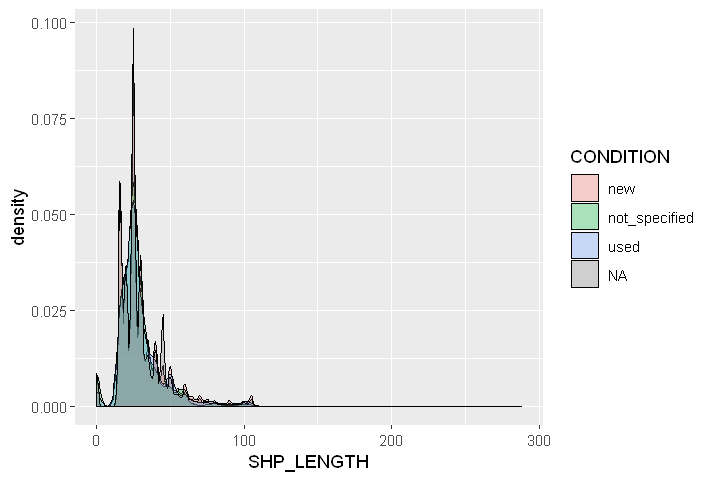

In [17]:
describeBy(df$SHP_LENGTH,df$CONDITION ,IQR=TRUE)

ggplot(df, aes(CONDITION, SHP_LENGTH))+
  geom_boxplot(aes(fill=CONDITION))

ggplot(df, aes(SHP_LENGTH )) + 
  geom_density( aes(fill = CONDITION), alpha=0.3)


### Analisis univariado de SHP_LENGTH discriminando por STATUS


 Descriptive statistics by group 
group: 404
   vars     n mean    sd median trimmed  mad min max range skew kurtosis   se
X1    1 51426 31.6 16.64  25.35   29.39 8.38   0 245   245 1.92     6.75 0.07
   IQR
X1  17
------------------------------------------------------------ 
group: active
   vars      n  mean    sd median trimmed   mad min max range skew kurtosis
X1    1 161502 31.78 18.72     25   28.76 10.38   0 275   275  2.3     8.85
     se IQR
X1 0.05  17
------------------------------------------------------------ 
group: closed
   vars     n mean    sd median trimmed   mad min max range skew kurtosis   se
X1    1 18442   34 21.89     25   30.04 13.34   0 203   203 1.76     3.57 0.16
   IQR
X1  20
------------------------------------------------------------ 
group: inactive
   vars    n  mean    sd median trimmed  mad min max range skew kurtosis   se
X1    1 3026 27.83 14.13     25   25.74 7.41   0 137   137 2.11     7.61 0.26
   IQR
X1  10
------------------------------------

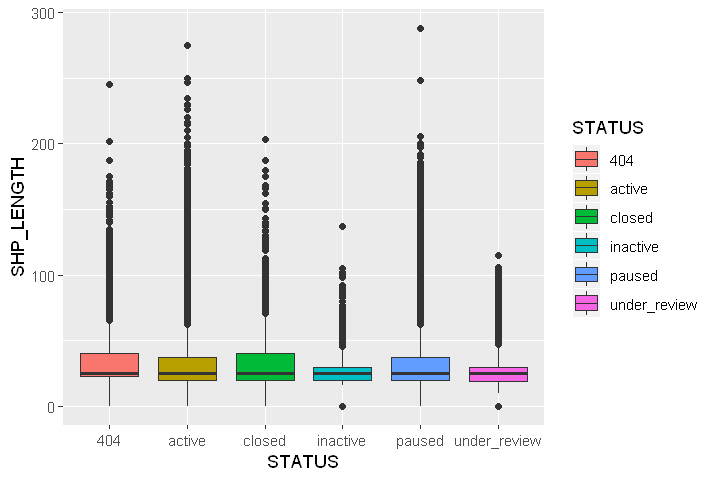

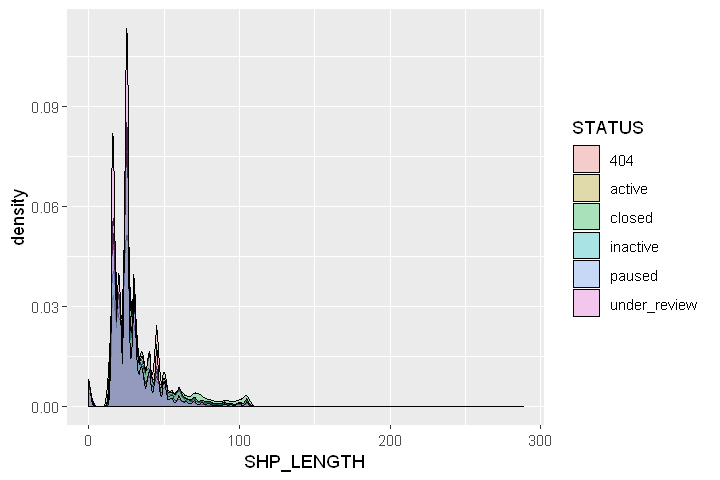

In [18]:
describeBy(df$SHP_LENGTH,df$STATUS ,IQR=TRUE)

ggplot(df, aes(STATUS, SHP_LENGTH))+
  geom_boxplot(aes(fill=STATUS)) 

ggplot(df, aes(SHP_LENGTH )) + 
  geom_density( aes(fill = STATUS), alpha=0.3)

### Analisis univariado de SHP_WIDTH

Warning message in describeBy(df$SHP_WIDTH, IQR = TRUE):
"no grouping variable requested"

,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
X1,1,347751,21.29028,11.21731,20,19.84083,8.8956,0,165,165,1.448877,4.01007,0.01902192


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


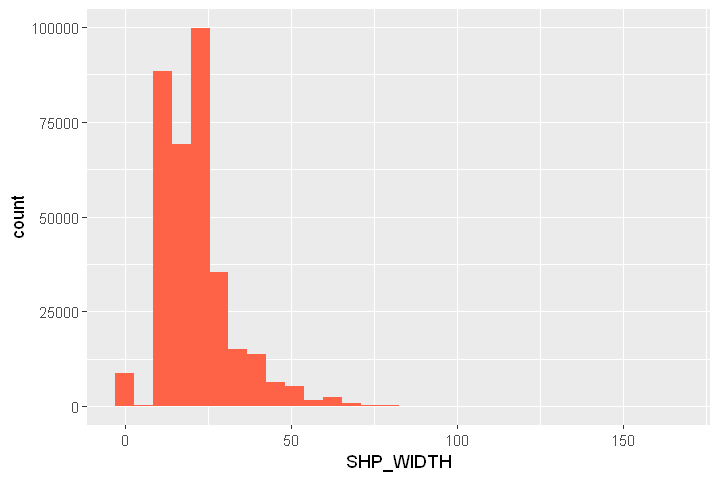

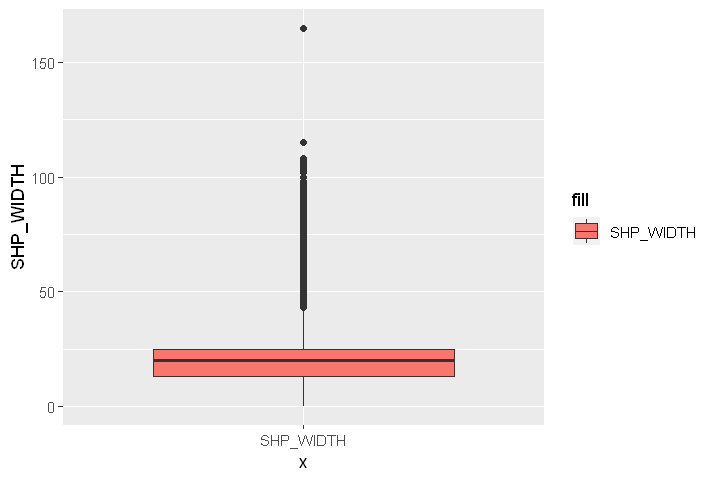

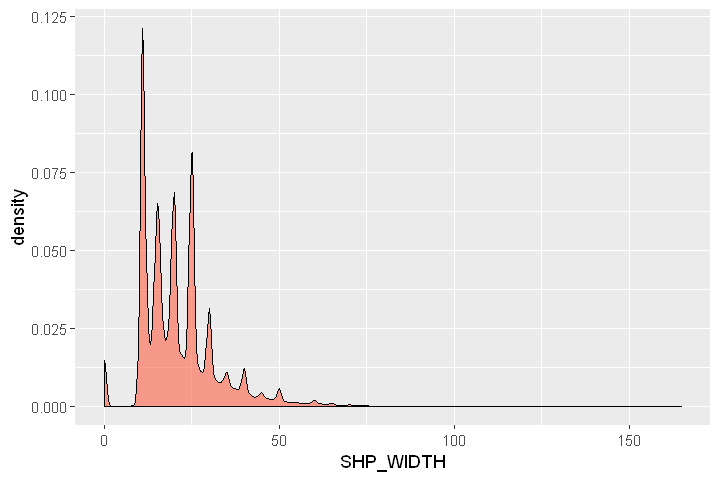

In [19]:
describeBy(df$SHP_WIDTH , IQR=TRUE)

ggplot(df, aes(SHP_WIDTH))+
  geom_histogram(fill = "tomato")

ggplot(df, aes(x="SHP_WIDTH", SHP_WIDTH))+
  geom_boxplot(aes(fill = "SHP_WIDTH"))

ggplot(df, aes(SHP_WIDTH)) + 
  geom_density( fill = "tomato", alpha=0.6)

### Analisis univariado de SHP_WIDTH discriminando por CONDITION


 Descriptive statistics by group 
group: new
   vars      n  mean    sd median trimmed mad min max range skew kurtosis   se
X1    1 260579 21.61 11.48     20   20.13 8.9   0 165   165 1.44     3.96 0.02
    IQR
X1 12.6
------------------------------------------------------------ 
group: not_specified
   vars   n  mean   sd median trimmed mad min max range skew kurtosis   se IQR
X1    1 356 19.26 9.28     19   18.62 8.9   0  57    57 0.78     1.94 0.49  13
------------------------------------------------------------ 
group: used
   vars    n mean   sd median trimmed   mad min max range skew kurtosis   se
X1    1 1023 19.9 11.1     18   18.29 10.38   0  68    68 1.34     2.37 0.35
   IQR
X1  14

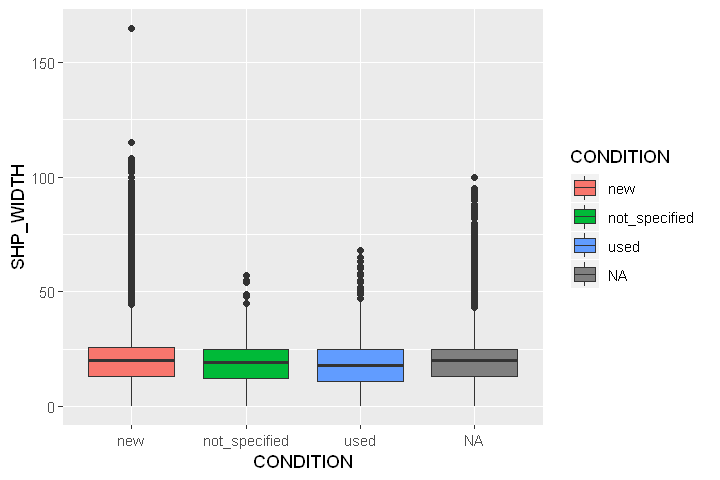

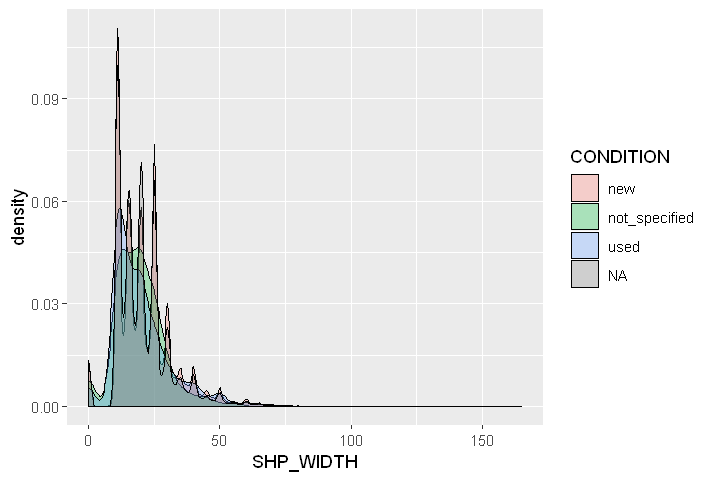

In [20]:
describeBy(df$SHP_WIDTH,df$CONDITION ,IQR=TRUE)

ggplot(df, aes(CONDITION, SHP_WIDTH))+
  geom_boxplot(aes(fill=CONDITION))

ggplot(df, aes(SHP_WIDTH )) + 
  geom_density( aes(fill = CONDITION), alpha=0.3)

### Analisis univariado de SHP_WIDTH discriminando por STATUS


 Descriptive statistics by group 
group: 404
   vars     n  mean    sd median trimmed  mad min max range skew kurtosis   se
X1    1 51426 21.13 10.72     20   19.81 7.41   0 100   100 1.36      3.5 0.05
   IQR
X1  11
------------------------------------------------------------ 
group: active
   vars      n  mean    sd median trimmed mad min max range skew kurtosis   se
X1    1 161502 21.68 11.29     20   20.31 8.9   0 115   115 1.42     4.23 0.03
     IQR
X1 12.08
------------------------------------------------------------ 
group: closed
   vars     n  mean    sd median trimmed   mad min max range skew kurtosis  se
X1    1 18442 22.16 13.17     20   20.17 11.86   0  95    95  1.6     3.61 0.1
   IQR
X1  14
------------------------------------------------------------ 
group: inactive
   vars    n  mean  sd median trimmed   mad min max range skew kurtosis   se
X1    1 3026 19.27 9.1     18   18.33 10.38   0  82    82 1.49     5.41 0.17
   IQR
X1  13
------------------------------------

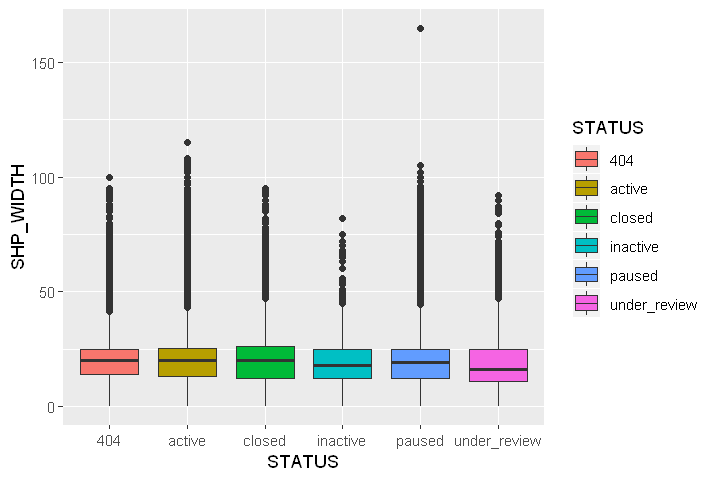

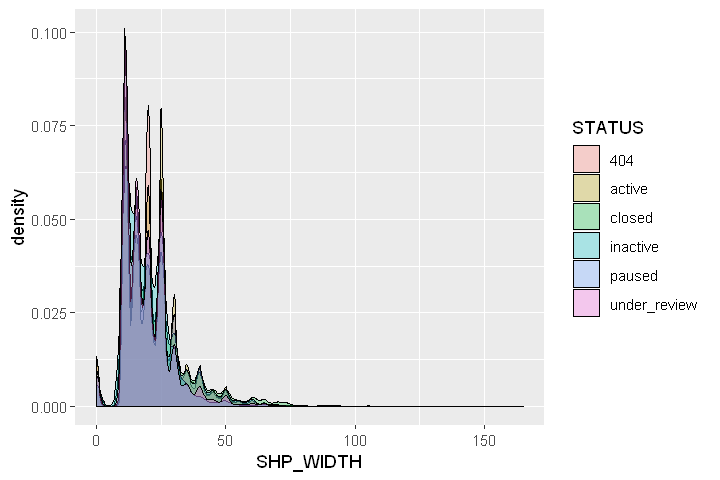

In [21]:
describeBy(df$SHP_WIDTH,df$STATUS ,IQR=TRUE)

ggplot(df, aes(STATUS, SHP_WIDTH))+
  geom_boxplot(aes(fill=STATUS))

ggplot(df, aes(SHP_WIDTH )) + 
  geom_density( aes(fill = STATUS), alpha=0.3)

### Analisis univariado de SHP_HEIGHT

Warning message in describeBy(df$SHP_HEIGHT, IQR = TRUE):
"no grouping variable requested"

,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
X1,1,347751,11.57858,8.310821,10,10.4526,7.413,0,105,105,1.423123,2.942553,0.0140932


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


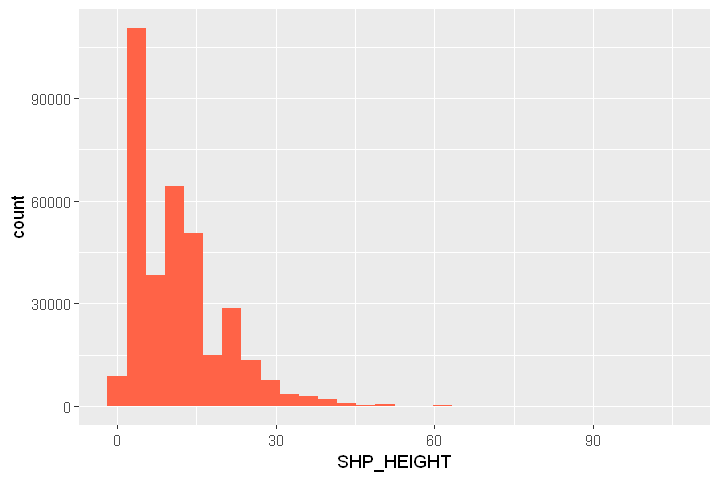

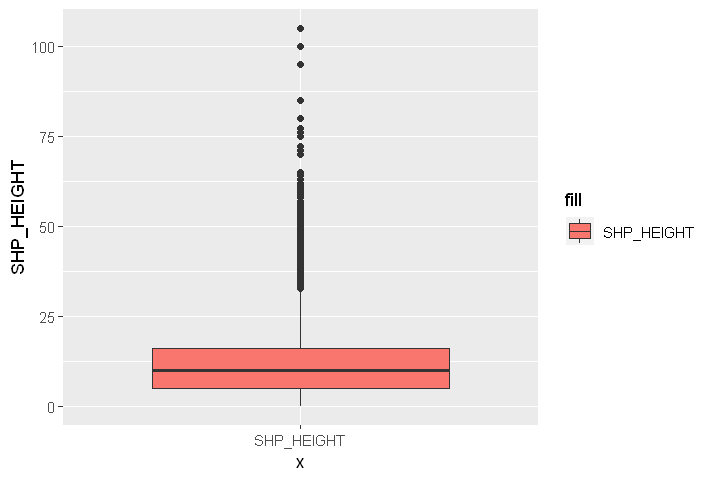

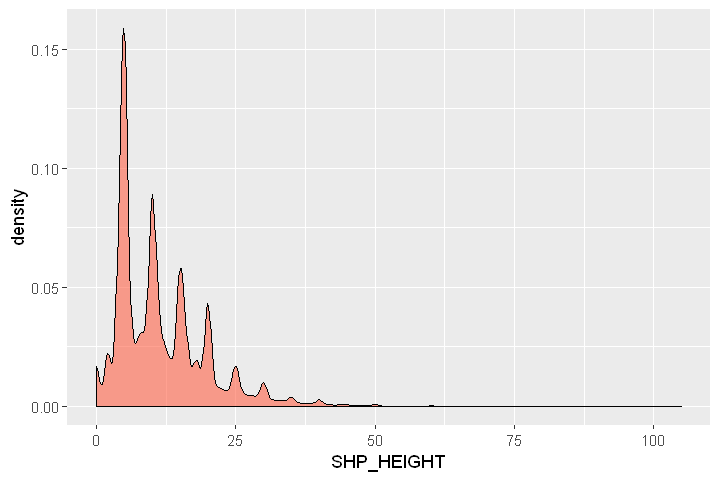

In [22]:
describeBy(df$SHP_HEIGHT , IQR=TRUE)

ggplot(df, aes(SHP_HEIGHT))+
  geom_histogram(fill = "tomato")

ggplot(df, aes(x="SHP_HEIGHT", SHP_HEIGHT))+
  geom_boxplot(aes(fill = "SHP_HEIGHT"))

ggplot(df, aes(SHP_HEIGHT)) + 
  geom_density( fill = "tomato", alpha=0.6)

### Analisis univariado de SHP_HEIGHT discriminando por CONDITION


 Descriptive statistics by group 
group: new
   vars      n  mean   sd median trimmed  mad min max range skew kurtosis   se
X1    1 260579 11.77 8.46     10   10.64 7.41   0 105   105 1.39     2.81 0.02
   IQR
X1  11
------------------------------------------------------------ 
group: not_specified
   vars   n mean   sd median trimmed  mad min max range skew kurtosis   se IQR
X1    1 356 10.9 7.21     10   10.26 7.41   0  42    42 1.08     1.58 0.38  10
------------------------------------------------------------ 
group: used
   vars    n  mean   sd median trimmed  mad min max range skew kurtosis   se
X1    1 1023 11.39 8.29     10   10.28 7.41   0  52    52 1.51     3.01 0.26
   IQR
X1  11

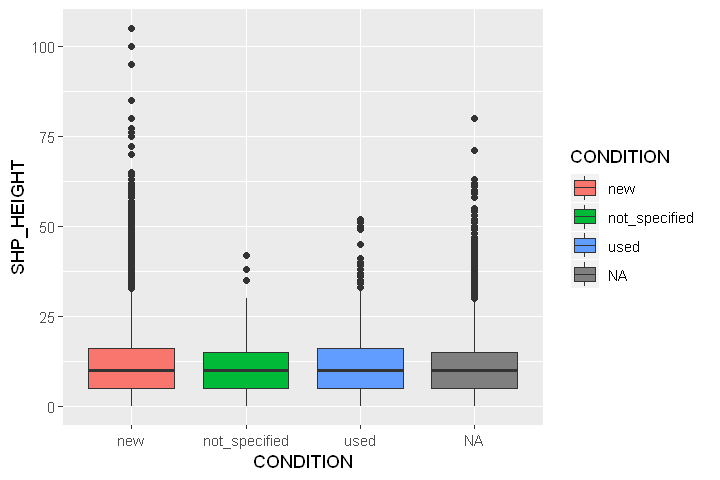

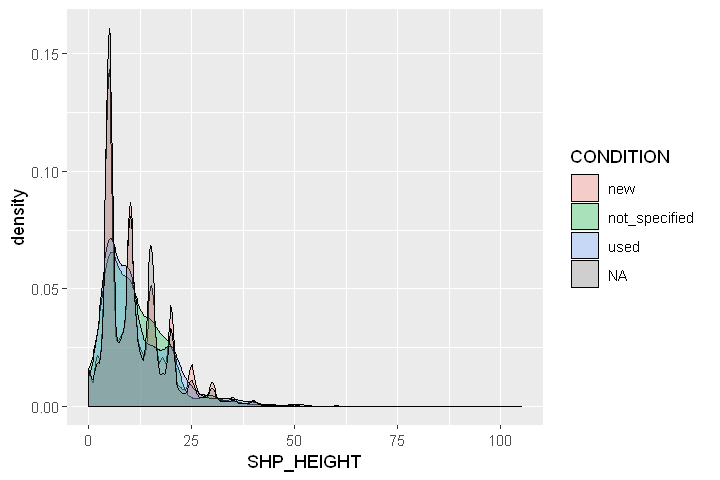

In [23]:
describeBy(df$SHP_HEIGHT,df$CONDITION ,IQR=TRUE)

ggplot(df, aes(CONDITION, SHP_HEIGHT))+
  geom_boxplot(aes(fill=CONDITION))

ggplot(df, aes(SHP_HEIGHT )) + 
  geom_density( aes(fill = CONDITION), alpha=0.3)

### Analisis univariado de SHP_HEIGHT discriminando por STATUS


 Descriptive statistics by group 
group: 404
   vars     n  mean   sd median trimmed  mad min max range skew kurtosis   se
X1    1 51426 11.67 8.03     10   10.61 7.41   0  80    80 1.44     3.08 0.04
   IQR
X1  10
------------------------------------------------------------ 
group: active
   vars      n  mean   sd median trimmed  mad min max range skew kurtosis   se
X1    1 161502 11.76 8.34     10   10.67 7.41   0 105   105 1.31     2.39 0.02
   IQR
X1  11
------------------------------------------------------------ 
group: closed
   vars     n  mean   sd median trimmed  mad min max range skew kurtosis   se
X1    1 18442 11.97 9.06     10   10.68 7.41   0  63    63 1.49     2.94 0.07
   IQR
X1  11
------------------------------------------------------------ 
group: inactive
   vars    n mean   sd median trimmed  mad min max range skew kurtosis   se IQR
X1    1 3026 9.95 6.88      9    9.04 5.93   0  51    51 1.57     3.82 0.13  10
----------------------------------------------------

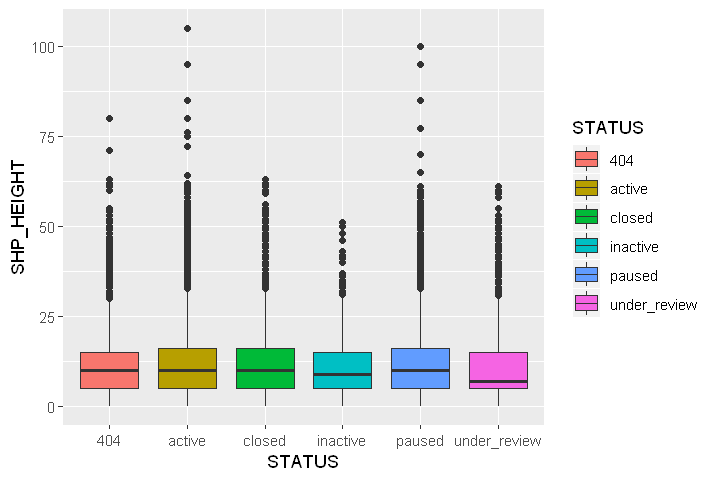

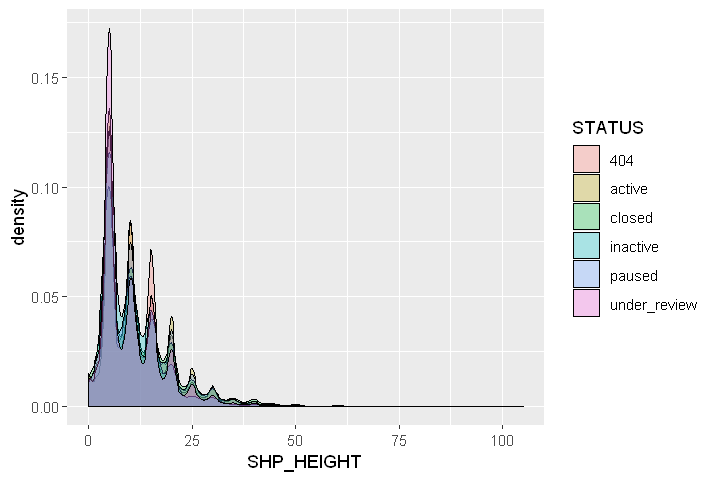

In [24]:
describeBy(df$SHP_HEIGHT,df$STATUS ,IQR=TRUE)

ggplot(df, aes(STATUS, SHP_HEIGHT))+
  geom_boxplot(aes(fill=STATUS))

ggplot(df, aes(SHP_HEIGHT )) + 
  geom_density( aes(fill = STATUS), alpha=0.3)

### Conclusiones sobre las distribuciones de las variables a predecir

Se aprecia que las cuatro variables a predecir tienen distribuciones con asimetría izquierda bastante marcada, especialmente el peso de los productos. Adempas las cuatro distribuciones son leptocúrticas o sea mas puntiagudas de que la distribución normal. También puede decirse que las variables no tienen distribuciones tan heterogéneas como se podría esperar, pero sí presentan múltiples outliers.